In [3]:
import os
import cv2
import sys
import numpy as np
from glob import glob
from tqdm import tqdm
from scipy.ndimage import correlate
from scipy.ndimage.morphology import distance_transform_edt

eps = sys.float_info.epsilon


def calculate_measures(gt_dir, sm_dir, measures, save=False, beta=np.sqrt(0.3), gt_threshold=0.5):
    """
    function that calculates Saliency measures for given directories

    arameters
    ----------
    gt_dir : str
        The path to the ground truth directory
    sm_dir : str
        The path to the predicted saliency map directory
    measures : list
        list of measure names which need to be calculated
        supported measures: 'MAE'       => Mean Squared Error
                            'E-measure' =>  Enhanced-alignment measure
                            'S-measure' =>  Structure-measure
                            'Max-F'     =>  Maximum F-measure
                            'Adp-F'     =>  Adaptive F-measure
                            'Wgt-F'     =>  Weighted F-measure
    save : str
        If spesified, the results will be saved in 'save' directory
    beta : float
        beta parameter that is used in F-measure formula. default is sqrt(0.3)
    gt_threshold : float
        The threshold that is used to binrize ground truth maps.

    Returns
    -------
    values : dictionary
        a dict containing the results
    """

    values = dict()
    for idx in measures:
        values[idx] = list()
        if idx == 'Max-F':
            values['Precision'] = list()
            values['Recall']    = list()

    for gt_name in tqdm(glob(os.path.join(gt_dir, '*'))):
        _, name = os.path.split(gt_name)
        sm_name = os.path.join(sm_dir, name)

        if os.path.exists(sm_name):

            gt, sm = read_and_normalize(gt_name, sm_name, gt_threshold)

            if 'MAE' in measures:
                values['MAE'].append(mean_square_error(gt, sm))
            if 'E-measure' in measures:
                values['E-measure'].append(e_measure(gt, sm))
            if 'S-measure' in measures:
                values['S-measure'].append(s_measure(gt, sm))
            if 'Adp-F' in measures:
                values['Adp-F'].append(adaptive_fmeasure(gt, sm, beta))
            if 'Wgt-F' in measures:
                values['Wgt-F'].append(weighted_fmeasure(gt, sm))
            if 'Max-F' in measures:
                prec, recall = prec_recall(gt, sm, 256)  # 256 thresholds between 0 and 1
                values['Precision'].append(prec)
                values['Recall'].append(recall)
        else:
            print("\n{} not found!".format(os.path.basename(sm_name)))
            print('---' * 10)

    if 'MAE' in measures:
        values['MAE'] = np.mean(values['MAE'])

    if 'E-measure' in measures:
        values['E-measure'] = np.mean(values['E-measure'])

    if 'S-measure' in measures:
        values['S-measure'] = np.mean(values['S-measure'])

    if 'Adp-F' in measures:
        values['Adp-F'] = np.mean(values['Adp-F'])

    if 'Wgt-F' in measures:
        values['Wgt-F'] = np.mean(values['Wgt-F'])

    if 'Max-F' in measures:
        values['Precision'] = np.mean(np.hstack(values['Precision'][:]), 1)
        values['Recall'] = np.mean(np.hstack(values['Recall'][:]), 1)
        f_measures = (1 + beta ** 2) * values['Precision'] * values['Recall'] / (
                beta ** 2 * values['Precision'] + values['Recall'])
        values['Fmeasure_all_thresholds'] = f_measures
        values['Max-F'] = np.max(f_measures)

    if save:
        if not os.path.isdir(save):
            os.mkdir(save)
        for key in values.keys():
            np.save(os.path.join(save, key + ".npy"), values[key])

    return values


def read_and_normalize(gt_path, sm_path, gt_threshold=0.5):
    """
    function that reads, normalizes and crops a ground truth and a saliency map

    parameters
    ----------
    gt_path : str
        The path to a ground truth map
    sm_path : str
        The path to a predicted saliency map
    gt_threshold : float
        The threshold that is used to binrize ground truth maps.

    Returns
    -------
    gt_img, sm_img : numpy.ndarray
        The prepared arrays
    """
    gt_img = norm_img(cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE))
    gt_img = (gt_img >= gt_threshold).astype(np.float32)
    sm_img = norm_img(cv2.imread(sm_path, cv2.IMREAD_GRAYSCALE))
    if sm_img.shape[0] != gt_img.shape[0] or sm_img.shape[1] != gt_img.shape[1]:
        sm_img = cv2.resize(sm_img, (gt_img.shape[1], gt_img.shape[0]))

    return gt_img, sm_img


def norm_img(im):
    return cv2.normalize(im.astype('float'),
                         None,
                         0.0, 1.0,
                         cv2.NORM_MINMAX)


# MAE
def mean_square_error(gt, sm):
    return np.mean(np.abs(sm - gt))


# E-measure
# article: https://arxiv.org/abs/1805.10421
# original code [Matlab]: https://github.com/DengPingFan/E-measure
def e_measure(gt, sm):
    """
    This fucntion computes the Enhanced-alignment Measure (E-Measure) between the saliency map and the ground truth
    article: https://arxiv.org/abs/1805.10421
    original code [Matlab]: https://github.com/DengPingFan/E-measure

    parameters
    ----------
    gt : numpy.ndarray
        The path to the ground truth directory
    sm : numpy.ndarray
        The path to the predicted saliency map directory

    Returns
    -------
    value : float
        The calculated E-masure
    """
    sm = adptive_binary(sm)

    gt = gt.astype(np.bool_)
    sm = sm.astype(np.bool_)

    dgt = gt.astype(np.float32)
    dsm = sm.astype(np.float32)

    if np.sum(dgt) == 0:  # if the gt is completely black
        enhanced_matrix = 1.0 - dsm  # only calculate the black area of intersection
    elif np.mean(dgt) == 1:  # if the gt is completely white
        enhanced_matrix = dsm  # only calcualte the white area of intersection
    else:
        # Normal case:
        # 1.compute alignment matrix
        align_matrix = alignment_term(dsm, dgt)
        # 2.compute enhanced alignment matrix
        enhanced_matrix = enhanced_alignment_term(align_matrix)

    height, width = gt.shape
    value = np.sum(enhanced_matrix) / (height * width - 1 + eps)
    return value


def alignment_term(dgt, dsm):
    # compute global mean
    mu_fm = np.mean(dsm)
    mu_gt = np.mean(dgt)

    # compute the bias matrix
    align_fm = dsm - mu_fm
    align_gt = dgt - mu_gt

    # compute alignment matrix
    align_Matrix = 2 * (align_gt * align_fm) / (align_gt * align_gt + align_fm * align_fm + eps)
    return align_Matrix


def enhanced_alignment_term(align_matrix):
    enhanced = ((align_matrix + 1) ** 2) / 4
    return enhanced


def adptive_binary(sm):
    adaptive_threshold = 2 * np.mean(sm)

    if adaptive_threshold > 1:
        adaptive_threshold = 1

    binary_sm = (sm >= adaptive_threshold).astype(np.float32)

    return binary_sm


# S-Measure
# article: https://www.crcv.ucf.edu/papers/iccv17/1164.pdf
# Matlab code: https://github.com/DengPingFan/S-measure
def s_measure(gt, sm):
    """
    This fucntion computes the structural similarity (S-Measure) between the saliency map and the ground truth
    article: https://www.crcv.ucf.edu/papers/iccv17/1164.pdf
    original code [Matlab]: https://github.com/DengPingFan/S-measure

    parameters
    ----------
    gt : numpy.ndarray
        The path to the ground truth directory
    sm : numpy.ndarray
        The path to the predicted saliency map directory

    Returns
    -------
    value : float
        The calculated S-masure
    """
    gt_mean = np.mean(gt)

    if gt_mean == 0:  # if the GT is completely black
        sm_mean = np.mean(sm)
        measure = 1.0 - sm_mean  # only calculate the area of intersection
    elif gt_mean == 1:  # if the GT is completely white
        sm_mean = np.mean(sm)
        measure = sm_mean.copy()  # only calcualte the area of intersection
    else:
        alpha = 0.5
        measure = alpha * s_object(sm, gt) + (1 - alpha) * s_region(sm, gt)
        if measure < 0:
            measure = 0

    return measure


def ssim(gt, sm):
    gt = gt.astype(np.float32)

    height, width = sm.shape
    num_pixels = width * height

    # Compute the mean of SM,GT
    sm_mean = np.mean(sm)
    gt_mean = np.mean(gt)

    # Compute the variance of SM,GT
    sigma_x2 = np.sum(np.sum((sm - sm_mean) ** 2)) / (num_pixels - 1 + eps)
    sigma_y2 = np.sum(np.sum((gt - gt_mean) ** 2)) / (num_pixels - 1 + eps)

    # Compute the covariance
    sigma_xy = np.sum(np.sum((sm - sm_mean) * (gt - gt_mean))) / (num_pixels - 1 + eps)

    alpha = 4 * sm_mean * gt_mean * sigma_xy
    beta = (sm_mean ** 2 + gt_mean ** 2) * (sigma_x2 + sigma_y2)

    if alpha != 0:
        ssim_value = alpha / (beta + eps)
    elif alpha == 0 and beta == 0:
        ssim_value = 1.0
    else:
        ssim_value = 0

    return ssim_value


def divide_sm(sm, x, y):
    # copy the 4 regions
    lt = sm[:y, :x]
    rt = sm[:y, x:]
    lb = sm[y:, :x]
    rb = sm[y:, x:]

    return lt, rt, lb, rb


def divide_gt(gt, x, y):
    height, width = gt.shape
    area = width * height

    # copy the 4 regions
    lt = gt[:y, :x]
    rt = gt[:y, x:]
    lb = gt[y:, :x]
    rb = gt[y:, x:]

    # The different weight (each block proportional to the GT foreground region).
    w1 = (x * y) / area
    w2 = ((width - x) * y) / area
    w3 = (x * (height - y)) / area
    w4 = 1.0 - w1 - w2 - w3

    return lt, rt, lb, rb, w1, w2, w3, w4


def centroid(gt):
    # col
    rows, cols = gt.shape

    if np.sum(gt) == 0:
        x = np.round(cols / 2)
        y = np.round(rows / 2)
    else:
        total = np.sum(gt)
        i = np.arange(cols).reshape(1, cols) + 1
        j = np.arange(rows).reshape(rows, 1) + 1

        x = int(np.round(np.sum(np.sum(gt, 0, keepdims=True) * i) / total))
        y = int(np.round(np.sum(np.sum(gt, 1, keepdims=True) * j) / total))

    return x, y


def s_region(gt, sm):
    x, y = centroid(gt)
    gt_1, gt_2, gt_3, gt_4, w1, w2, w3, w4 = divide_gt(gt, x, y)

    sm_1, sm_2, sm_3, sm_4 = divide_sm(sm, x, y)

    q1 = ssim(sm_1, gt_1)
    q2 = ssim(sm_2, gt_2)
    q3 = ssim(sm_3, gt_3)
    q4 = ssim(sm_4, gt_4)

    region_value = w1 * q1 + w2 * q2 + w3 * q3 + w4 * q4

    return region_value


def object(gt, sm):
    x = np.mean(sm[gt == 1])
    # compute the standard deviations of the foreground or background in sm
    sigma_x = np.std(sm[gt == 1])
    score = 2.0 * x / (x ** 2 + 1.0 + sigma_x + eps)
    return score


def s_object(gt, sm):
    # compute the similarity of the foreground in the object level

    sm_fg = sm.copy()
    sm_fg[gt == 0] = 0
    o_fg = object(sm_fg, gt)

    # compute the similarity of the background
    sm_bg = 1.0 - sm.copy()
    sm_bg[gt == 1] = 0
    o_bg = object(sm_bg, gt == 0)

    u = np.mean(gt)
    object_value = u * o_fg + (1 - u) * o_bg
    return object_value



# Weighted F-Measure
# article: https://ieeexplore.ieee.org/document/6909433
# Matlab code: https://cgm.technion.ac.il/Computer-Graphics-Multimedia/Software/FGEval/
def weighted_fmeasure(gt, sm, beta2=1):
    """
    This fucntion computes Weighted F-Measure between the saliency map and the ground truth
    article: https://ieeexplore.ieee.org/document/6909433
    original code [Matlab]: https://cgm.technion.ac.il/Computer-Graphics-Multimedia/Software/FGEval/

    parameters
    ----------
    gt : numpy.ndarray
        The path to the ground truth directory
    sm : numpy.ndarray
        The path to the predicted saliency map directory

    Returns
    -------
    value : float
        The calculated Weighted F-Measure
    """
    dst, idx = distance_transform_edt(1 - gt, return_indices=True)

    raw_idx = idx[0][gt == 0]
    col_idx = idx[1][gt == 0]

    e = np.abs(sm - gt).astype(np.float32)
    et = np.abs(sm - gt).astype(np.float32)

    et[gt == 0] = et[raw_idx, col_idx]

    k = matlab_style_gauss2d(shape=(7, 7), sigma=5)

    ea = correlate(et.astype(np.float32), k, mode='constant')
    min_e_ea = np.abs(sm - gt).astype(np.float32)

    min_e_ea[gt * (ea < e) == 1] = ea[gt * (ea < e) == 1]

    b = np.ones_like(gt).astype(np.float32)
    b[gt == 0] = 2 - 1 * np.exp(np.log(1 - 0.5) / 5. * dst[gt == 0])

    ew = min_e_ea * b
    tpw = np.sum(gt) - np.sum(ew[gt == 1])
    fpw = np.sum(ew[gt == 0])

    rec = 1 - np.mean(ew[gt == 1])  # Weighed Recall
    prec = tpw / (eps + tpw + fpw)  # Weighted Precision

    value = (1 + beta2) * (rec * prec) / (eps + (beta2 * rec) + prec)
    return value

def matlab_style_gauss2d(shape=(3, 3), sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h



# Adaptive F-measure

def adaptive_fmeasure(gt, sm, beta):
    """
    This fucntion computes Adaptive F-measure between the saliency map and the ground truth using
    the binary method proposed in:
    https://ieeexplore.ieee.org/document/5206596

    parameters
    ----------
    gt : numpy.ndarray
        The path to the ground truth directory
    sm : numpy.ndarray
        The path to the predicted saliency map directory

    Returns
    -------
    value : float
        The calculated Adaptive F-measure
    """
    gt_idx = np.where(gt > 0)
    gt_cnt = np.sum(gt)

    if gt_cnt == 0:
        prec = []
        recall = []
    else:
        adaptive_threshold = 2 * np.mean(sm)
        if adaptive_threshold > 1:
            adaptive_threshold = 1
        sm_binary = (sm >= adaptive_threshold).astype(np.float32)
        hit_cnt = np.sum(sm_binary[gt_idx])
        alg_cnt = np.sum(sm_binary)

        if hit_cnt == 0:
            prec = 0
            recall = 0
        else:
            prec = hit_cnt / (alg_cnt + eps)
            recall = hit_cnt / gt_cnt
    value = (1 + beta ** 2) * prec * recall / ((beta ** 2 * prec + recall) + eps)
    return value



def prec_recall(gt, sm, num_th):
    """
    This fucntion computes Adaptive F-measure between the saliency map and the ground truth using
    the binary method proposed in:
    https://ieeexplore.ieee.org/document/5206596
    The results of this dunction will be used to calculate Max-F measure and plot PR and F-Threshold Curves
    parameters
    ----------
    gt : numpy.ndarray
        The path to the ground truth directory
    sm : numpy.ndarray
        The path to the predicted saliency map directory
    num_th : interger
        The total number of thresholds between 0 and 1
    Returns
    -------
    prec, recall:  numpy.ndarray
        The calculated Precision and Recall (shape: (num_th,1))
    """
    gt_idx = np.where(gt > 0)
    gt_cnt = np.sum(gt)

    if gt_cnt == 0:
        prec = []
        recall = []
    else:
        hit_cnt = np.zeros((num_th, 1), np.float32)
        alg_cnt = np.zeros((num_th, 1), np.float32)
        thresholds = np.linspace(0, 1, num_th)
        for k, curTh in enumerate(thresholds):
            sm_binary = (sm >= curTh).astype(np.float32)
            hit_cnt[k] = np.sum(sm_binary[gt_idx])
            alg_cnt[k] = np.sum(sm_binary)

        prec = hit_cnt / (alg_cnt + eps)
        recall = hit_cnt / gt_cnt

    return prec, recall

/tmp/ipykernel_33/1429582481.py:8: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt


In [4]:
from pathlib import Path

cod_path = Path("/kaggle/input/cod10k")
train_gt_path = cod_path/"COD10K-v2/Train/GT_Objects/GT_Object"
train_gt_list_1 = sorted(list(train_gt_path.glob("*.png")))
train_gt_list_2 = sorted(list(train_gt_path.glob("*.png")),reverse = True)

In [5]:
train_gt_path_list_1 = 

PosixPath('/kaggle/input/cod10k/COD10K-v2/Train/GT_Objects/GT_Object')

In [94]:
import random
from PIL import Image

random_idx = random.randint(0,len(train_gt_list_1))
sample_gt_1 = train_gt_list_1[random_idx]
sample_gt_2 = train_gt_list_2[random_idx]

In [7]:
type(sample_gt_1)

pathlib.PosixPath

In [8]:
import sys
sys.setrecursionlimit(8710)

In [148]:
sm_dir = str(train_gt_path)
gt_dir = str(train_gt_path)
a = calculate_measures(gt_dir, sm_dir, ['E-measure','S-measure','MAE'], save = False)
print(a)
#res = calculate_measures(gt_dir, sm_dir,['E-measure', 'S-measure', 'Wgt-F'], save = False)
#print(res)

100%|██████████| 6000/6000 [03:14<00:00, 30.85it/s]

{'E-measure': 0.5066674759095787, 'S-measure': 0.9999858140249962, 'MAE': 0.0}


## Read and Normalize

In [ ]:
b = read_and_normalize(sample_gt_2,sample_gt_1)
print(b)

## Manual E Measure.

In [136]:
import random
from PIL import Image

random_idx = random.randint(0,len(train_gt_list_1))
sample_gt_1 = train_gt_list_1[random_idx]
sample_gt_2 = train_gt_list_2[random_idx]

In [143]:
gt_np_1 = np.array(Image.open(sample_gt_1))
gt_np_2 = np.array(Image.open(sample_gt_2))

In [12]:
gt_np_1.shape, gt_np_2.shape

((768, 1024), (533, 799))

In [13]:
gt_np_1.shape[1]

1024

In [140]:
gt_np_random = np.random.rand(gt_np_1.shape[0],gt_np_1.shape[1])
e_measure(gt_np_1, gt_np_random)

0.3032624300001865

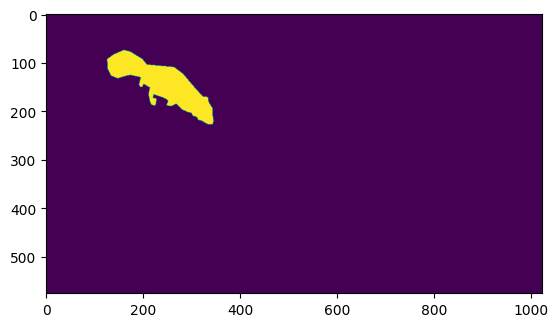

In [138]:
import matplotlib.pyplot as plt
plt.imshow(gt_np_1)

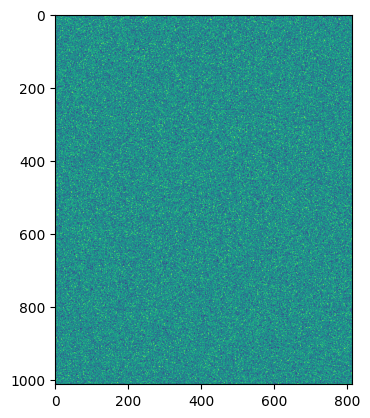

In [139]:
plt.imshow(gt_np_random)

## Manual S Measure

In [150]:
d = s_measure(gt_np_1, gt_np_random)
d

nan

## Weighted F Measure

In [153]:
e = weighted_fmeasure(gt_np_1, gt_np_random, beta2=1)
print(e)

nan


## Adaptive F-measure 1

In [146]:
f = adaptive_fmeasure(gt_np_1, gt_np_random, 1)
print(f)

1.0528881185601478e-05


## Adaptive F-measure 2

In [147]:
g = prec_recall(gt_np_1, gt_np_random, 1)
print(g)

(array([[0.02146573]], dtype=float32), array([[0.00392157]]))


In [ ]:
''' sm_dir = sample_gt_1
 gt_dir = sample_gt_2
 res    = calculate_measures(gt_dir, sm_dir, ['E-measure', 'S-measure', 'Wgt-F'], save=False)
 print(res)

{'E-measure': 0.990753, 'S-measure': 0.958684, 'Wgt-F': 0.974209}
'''

In [ ]:
'''import os

# Specify the directory you want to create
output_dir = '/kaggle/working/output'

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the file path
file_path = os.path.join(output_dir, 'my_output_file.csv')
open(os.path.join(output_dir, 'file.txt'), 'w')
'''

In [ ]:
 res = calculate_measures(gt_dir, sm_dir, ['Max-F'], save= False)
 prec = np.load('save/Precision.npy')
 recall = np.load('save/Recall.npy')
 f_measure = np.load('save/Fmeasure_all_thresholds.npy')
 plt.plot(recall, prec)
 plt.figure()
 plt.plot(np.linspace(0, 1, len(f_measure)), f_measure) 